In [1]:
#pip install gensim

# Import libraries

In [2]:
import pandas as pd
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import Word2Vec

from nltk.cluster import KMeansClusterer
import nltk

from sklearn.metrics import pairwise

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

C:\Users\athik\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\athik\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.o

# Word2Vec model

In [3]:
class Word2VecModel():
    
    def get_original_data(self,filename,column_name):
        '''read the data from given file'''
        return pd.read_csv(filename)[column_name]

    def get_feature_data(self,filename,indices):
        ''' read the data from given features file'''
        features = []
        for index in indices:
            features.extend(list(pd.read_csv(filename).iloc[:,index]))
        return features
    
    def get_tokens(self,data):
        ''' return word tokens for the data'''
        tokens=[]
        for i in data:
            tokens.append(word_tokenize(i))
        return tokens
    
    def get_embeddings(self,model, features):
        ''' get word embeddings for each feature
                - if the feature is unigram, word embedding is the w2v of that feature word
                - if the feature is not a unigram, word embedding is the average of the w2v of all the words in that feature
        '''
        
        X=[]
        X_dict = {}

        for i in features:
            if len(i.split())==1:
                X.append(model.wv[i])
                X_dict[i] = model.wv[i]
            else:
                words = i.split()
                a = [model.wv[words[j]] for j in range(len(words))]

                import numpy as np
                b = []
                for k in range(100):
                    s=0
                    for j in range(len(a)):
                        s = s+a[j][k]
                    av = s/len(a)
                    b.append(av)
                b = np.array(b)
                X.append(b)
                X_dict[i] = b

        return X, X_dict
    
    def get_model(self,tokens):
        ''' return the word2vec model built form the tokens'''
        model = Word2Vec()
        model.build_vocab(tokens)

        return model
    
    def get_w2v(self,data_filename, data_columns, features_filename, features_columns):
        ''' this method creates a word2vec model and gets embeddings for the features '''
        data = self.get_original_data(data_filename,data_columns)
        features = self.get_feature_data(features_filename,features_columns)

        model = self.get_model(self.get_tokens(data))

        X, X_dict = self.get_embeddings(model, features)

        return data, features, model, X, X_dict

# K-Means Clustering (using cosine affinity)

In [4]:
class KMeansNLTK():
    ''' this class contains methods for kmeans clustering (nltk) '''
    
    def nltk_kmeans(self,X,n_clusters):
        ''' perform kmeans clustering for given data (X) and number of clusters (k)'''
        
        kclusterer = KMeansClusterer(n_clusters, distance=nltk.cluster.util.cosine_distance, repeats=10, avoid_empty_clusters=True)
        assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

        return kclusterer,assigned_clusters
    
    def cluster_words(self,X_dict,assigned_clusters):
        ''' word_clusters : dictionary that maps each feature to its respective cluster index'''
        word_clusters = {}
        for i in range(len(X_dict.keys())):
            word_clusters[list(X_dict.keys())[i]]=assigned_clusters[i]

        ''' clusters : dictionary that stores cluster index and its corresponding feature words'''
        clusters = {}
        for i in range(max(assigned_clusters)+1):
            clusters[i] = []
        for i in list(X_dict.keys()):
            clusters[word_clusters[i]].append(i)

        return clusters
    
    def clustering_kmeans(self,X,X_dict,K):
        ''' find cluster words for each cluster '''
        kmeans, assigned_clusters = self.nltk_kmeans(X,K)
        return kmeans,assigned_clusters,self.cluster_words(X_dict, assigned_clusters)  
    
    def get_cluster_words_df(self,clusters):
        ''' convert cluster words into dataframe and make it a .csv file '''
        df = pd.DataFrame()
        df = pd.DataFrame.from_dict(clusters,orient='index').transpose()
        df.columns = ['cluster %s'%(i+1) for i in list(clusters.keys())]
        return df

# Evaluation metrics

In [5]:
class Metrics():
    ''' this class contains evaluation metrics to determine the best number of clusters(k) '''
    
    #SILHOUETTE SCORE
    def get_silhouette_scores(self,max_clusters, X, X_dict, kmeans_iter, labels_iter): 
        ''' computes silhouette scores for clusters ranging from 2 to max clusters(square root of n) '''
        silhouette_scores = {}
        
        kmeans_nltk = KMeansNLTK()
        
        for i in range(2,max_clusters):
            kmeans,labels, clusters = kmeans_nltk.clustering_kmeans(X,X_dict,i)

            a = pairwise.cosine_distances(X,kmeans_iter[i].means())

            from sklearn.metrics import silhouette_score
            silhouette_scores[i] = silhouette_score(a,labels_iter[i],metric='cosine')
        return silhouette_scores
        
    def get_CH_scores(self,max_clusters, X, X_dict, labels_iter): #CALANSKI HARABASZ SCORE
        ''' computes calanki harabasz scores for clusters ranging from 2 to max clusters(square root of n) '''
        ch_scores = {}
        
        kmeans_nltk = KMeansNLTK()
        
        for i in range(2,max_clusters):
            kmeans,labels, clusters = kmeans_nltk.clustering_kmeans(X,X_dict,i)

            from sklearn.metrics import calinski_harabasz_score
            ch_scores[i] = calinski_harabasz_score(X, labels_iter[i])
            #print(i,ch_scores[i])
        return ch_scores
        
    def get_DB_scores(self,max_clusters, X, X_dict, labels_iter): #DAVIES BOULDIN SCORE
        ''' computes davies bouldin scores for clusters ranging from 2 to max clusters(square root of n) '''
        db_scores = {}
        
        kmeans_nltk = KMeansNLTK()
        
        for i in range(2,max_clusters):
            kmeans,labels, clusters = kmeans_nltk.clustering_kmeans(X,X_dict,i)

            from sklearn.metrics import davies_bouldin_score
            db_scores[i] = davies_bouldin_score(X,labels_iter[i])
        return db_scores

    def plot_graph(self,scores,xlabel,ylabel,title,path):
        ''' plot graph for given scores '''
        
        x = np.array(list(scores.keys()))
        y = np.array(list(scores.values()))

        plt.xticks(x)
        plt.plot(x, y)
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        
        plt.savefig(path+ylabel+'.png', bbox_inches = 'tight')
        plt.show()
        

# Hierarchical Clustering (AGNES)

In [6]:
class Agnes():
    ''' this class computes AGNES clusters '''
    
    def cluster(self,X):
        ''' get agnes clustering object and agnes clusters for the given data(X) '''
        from sklearn.cluster import AgglomerativeClustering
        import numpy as np

        clustering = AgglomerativeClustering(n_clusters=None,affinity='cosine',linkage='complete',distance_threshold=1.2,compute_full_tree=True)
        #print(clustering)

        clustering = clustering.fit(X)
        labels = clustering.labels_
        #print(labels)
        
        return clustering, labels

    def get_clusters(self,labels,X_dict):
        ''' for each agnes cluster store the cluster words in a dictionary'''
        agnesclusters = {}
        for i in range(max(labels)+1):
            agnesclusters[i] = []
        for i in range(len(X_dict.keys())):
            agnesclusters[labels2[i]].append(list(X_dict.keys())[i])
        for i in range(max(labels2)+1):
            print(i,agnesclusters[i])
            print('------- no. of features = ',len(agnesclusters[i]))
            print('---------------')
        return agnesclusters

    def plot_dendrogram(self, model, **kwargs):
        # Create linkage matrix and then plot the dendrogram

        # create the counts of samples under each node
        
        from scipy.cluster.hierarchy import dendrogram, leaves_list
        
        counts = np.zeros(model.children_.shape[0])
        n_samples = len(model.labels_)

        leaf_nodes = []

        for i, merge in enumerate(model.children_):
            current_count = 0
            for child_idx in merge:
                if child_idx < n_samples:
                    current_count += 1  # leaf node
                    leaf_nodes.append(child_idx)
                else:
                    current_count += counts[child_idx - n_samples]
                    leaf_nodes.append(child_idx-n_samples)

            counts[i] = current_count

        linkage_matrix = np.column_stack(
            [model.children_, model.distances_, counts]
        ).astype(float)

        # Plot the corresponding dendrogram
        r = dendrogram(linkage_matrix, **kwargs)
        leaves = leaves_list(linkage_matrix)
        return r,leaves

    def get_leaf_nodes(self,r):
        ''' get the leaf nodes from the Agnes tree hierarchy 
            - if type of leaf node is number : represents number of words in the cluster
            - if type of leaf node is () : represents the index of the feature word 
        '''
        
        leaf_nodes = []
        idx = []
        import ast
        for i in range(len(r['ivl'])):
            if '(' not in r['ivl'][i]:
                idx.append(i)
                leaf_nodes.append(ast.literal_eval(r['ivl'][i]))
                continue
            leaf_nodes.append(ast.literal_eval(r['ivl'][i]))
        print(leaf_nodes,idx)
        return leaf_nodes,idx

    def get_cluster_words(self,leaf_nodes,idx,leaves_list):
        ''' get the cluster words for each cluster '''
        start = 0
        cluster_words = []
        for i in range(len(leaf_nodes)):
            if i not in idx:
                temp = leaves_list[start:start + leaf_nodes[i]]
                cluster_words.append(list(temp))
                start = start + leaf_nodes[i]
            else:
                temp = leaves_list[start:start+1]
                cluster_words.append(list(temp))
                start = start + 1
        return cluster_words
        
    def make_csv(self, NUM_CLUSTERS, agnesclusters):
        ''' convert agnes clusters to .csv file '''
        df2 = pd.DataFrame()
        for i in range(NUM_CLUSTERS):
            df2 = pd.concat([df2,pd.DataFrame(agnesclusters[i])], axis=1)
        df2.columns = ['agnes_cluster_%s' %(i+1) for i in range(NUM_CLUSTERS)]
        df2.to_csv('agnes_cluster_words.csv',index=False,header=True)
        return df2
        
        
    def find_agnes_clusters(self,X):
        ''' find agnes clusters main function '''
        clustering,labels = self.cluster(X)
        r,leaves_list = self.plot_dendrogram(clustering, truncate_mode='level', p=4, get_leaves=True)
        leaf_nodes,idx = self.get_leaf_nodes(r)
        cluster_words = self.get_cluster_words(leaf_nodes,idx,leaves_list)
        clusters_df = self.make_csv(NUM_CLUSTERS,agnes_clusters)
        plt.xlabel("Number of features in the node (or index of feature if no parenthesis).")
        plt.show()
        return clusters_df
        

# Cluster the feature words

In [7]:
class PerformClustering():
    ''' this class performs clustering K-Means and AGNES '''
    
    def __init__(self,object_dict):
        
        self.input_data_path = object_dict['input_data_path']
        self.feature_data_path = object_dict['feature_data_path']
        
        self.output_data_path = object_dict['output_data_path']
        self.clustering_results_dir = object_dict['clustering_results_dir']
        
        self.input_filename = object_dict['data_filename']
        self.feature_filename = object_dict['feature_filename']
        
        self.no_of_clusters = int(object_dict['no_of_clusters'])
        import ast
        self.feature_column_numbers = ast.literal_eval(object_dict['feature_columns'])
        
        self.raw_data = object_dict['raw_data']
        #-----------------------------------------------
        
        w2v_model = Word2VecModel()
        self.data_columns = 'text'
        
        self.data, self.features, self.model, self.X, self.X_dict = w2v_model.get_w2v(self.input_data_path + self.raw_data.split('.')[0] + self.input_filename, self.data_columns, self.feature_data_path + self.feature_filename, self.feature_column_numbers)
        print('Model created..')
        #-----------------------------------------------
        
        print('--Clustering using K-Means--')
        kmeans_nltk = KMeansNLTK()

        self.kmeans,self.labels, self.clusters = kmeans_nltk.clustering_kmeans(self.X,self.X_dict,self.no_of_clusters)

        import math
        self.max_clusters = math.ceil(math.sqrt(len(self.features)))
        #max_clusters

        self.kmeans_iter, self.labels_iter, self.clusters_iter = {},{},{}

        for i in range(2,self.max_clusters):
            #print(i)
            kmeans,labels,clusters = kmeans_nltk.clustering_kmeans(self.X,self.X_dict,i)
            self.kmeans_iter[i] = kmeans
            self.labels_iter[i] = labels
            self.clusters_iter[i] = clusters

        self.clusters_df = pd.DataFrame()
        for i in list(self.clusters_iter.keys()):
            self.clusters_df = kmeans_nltk.get_cluster_words_df(self.clusters_iter[i])
            #self.clusters_df = pd.concat([self.clusters_df, df],axis=1)
            self.clusters_df.to_csv(self.output_data_path + '%s clusters.csv'%(i), index=False, header=True)
            
        #------------------------------------------------
        
        print('--Metrics--')
        metrics = Metrics()
        
        self.silhouette_scores = metrics.get_silhouette_scores(self.max_clusters, self.X, self.X_dict, self.kmeans_iter, self.labels_iter)
        metrics.plot_graph(self.silhouette_scores,xlabel = 'number of clusters', ylabel = 'silhouette score', title = 'Silhouette scores', path = object_dict['output_data_path'])
        pd.DataFrame.from_dict(self.silhouette_scores,orient='index').to_csv(self.output_data_path + 'Silhouette scores.csv')
        
        self.ch_scores = metrics.get_CH_scores(self.max_clusters, self.X, self.X_dict, self.labels_iter)
        metrics.plot_graph(self.ch_scores, xlabel = 'number of clusters', ylabel = 'CH-score', title = 'CH-scores', path = object_dict['output_data_path'])
        pd.DataFrame.from_dict(self.ch_scores,orient='index').to_csv(self.output_data_path + 'CH-scores.csv')
        
        self.db_scores = metrics.get_DB_scores(self.max_clusters, self.X, self.X_dict, self.labels_iter)
        metrics.plot_graph(self.db_scores,xlabel = 'number of clusters', ylabel = 'DB-score', title = 'DB-scores', path = object_dict['output_data_path'])
        pd.DataFrame.from_dict(self.db_scores,orient='index').to_csv(self.output_data_path + 'DB scores.csv')
    

# Create Configuration file

In [8]:
%run ../conf/ClusteringConfiguration.py

# Main function

{'input_data_path': '../results/PreProcessing_Results/', 'feature_data_path': '../results/FeatureSelection_Results/', 'output_data_path': '../results/Clustering_Results/', 'raw_data': 'IMDBtrain.csv', 'data_filename': '_PreProcessed.csv', 'feature_filename': 'pearson_features.csv', 'clustering_results_dir': 'Clustering_Results', 'no_of_clusters': '10', 'feature_columns': '[2]'}
Model created..
--Clustering using K-Means--
--Metrics--


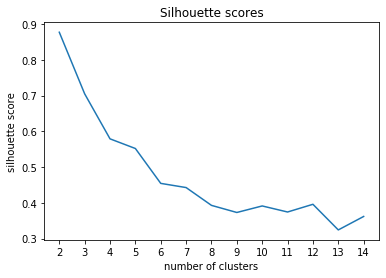

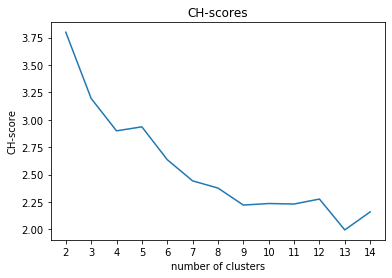

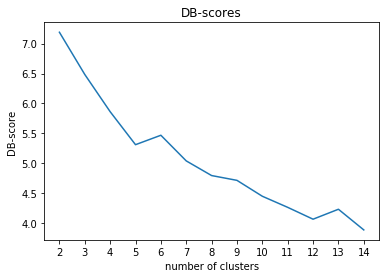

In [9]:
if __name__ == '__main__':
    
    from configparser import ConfigParser
    
    config = ConfigParser()
    config.read('../conf/clustering.ini') #read clustering configuration file
    
    config2 = ConfigParser()
    config2.read('../conf/Collocations.ini') #read collocations configuration file
    
    #read the values from configuration file and store them in a dictionary for further usage
    object_dict = dict()
    
    object_dict['input_data_path'] = config['Clustering']['input_data_path']
    object_dict['feature_data_path'] = config['Clustering']['feature_data_path']
    
    object_dict['output_data_path'] = config['Clustering']['output_data_path']
    object_dict['raw_data'] = config2['Collocations']['input_filename']
    
    object_dict['data_filename'] = config['Clustering']['data_filename']
    object_dict['feature_filename'] = config['Clustering']['feature_filename']
    
    object_dict['clustering_results_dir'] = config['Clustering']['clustering_results_dir']
    
    object_dict['no_of_clusters'] = config['Clustering']['no_of_clusters']
    object_dict['feature_columns'] = config['Clustering']['feature_column_numbers']
    print(object_dict)
    
    import os
    try:
        os.mkdir(object_dict['output_data_path'][:-1])
    except FileExistsError:
        pass
    
    result = PerformClustering(object_dict) #cluster the feature words